# Bart Analysis

Analysis of the open bart dataset

## TODO

* [ ] Sundays versus Weekday + Saturday
* [ ] Fare analysis

In [1]:
import pandas as pd
import altair as alt

alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [13]:
df = pd.concat(
    [
#         pd.read_csv(
#             "http://64.111.127.166/origin-destination/date-hour-soo-dest-2017.csv.gz",
#             header=None,
#         ),
#         pd.read_csv(
#             "http://64.111.127.166/origin-destination/date-hour-soo-dest-2018.csv.gz",
#             header=None,
#         ),
        pd.read_csv(
            "http://64.111.127.166/origin-destination/date-hour-soo-dest-2019.csv.gz",
            header=None,
        ),
    ]
)

In [14]:
df.shape

(8865720, 5)

In [15]:
df.columns = ["date", "hour", "start", "stop", "riders"]
df.head()

,date,hour,start,stop,riders
0,2019-01-01,0,12TH,12TH,3
1,2019-01-01,0,12TH,16TH,4
2,2019-01-01,0,12TH,ANTC,1
3,2019-01-01,0,12TH,BAYF,1
4,2019-01-01,0,12TH,CIVC,2


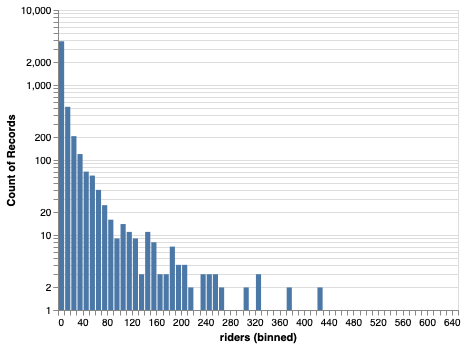

In [16]:
alt.Chart(df.sample(5000)).mark_bar().encode(
    x=alt.X("riders", bin=alt.Bin(maxbins=100)),
    y=alt.Y("count()", scale=alt.Scale(type="log")),
)

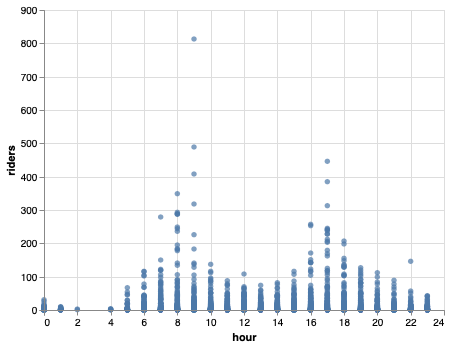

In [17]:
alt.Chart(df.sample(5000)).mark_circle().encode(x="hour", y="riders")

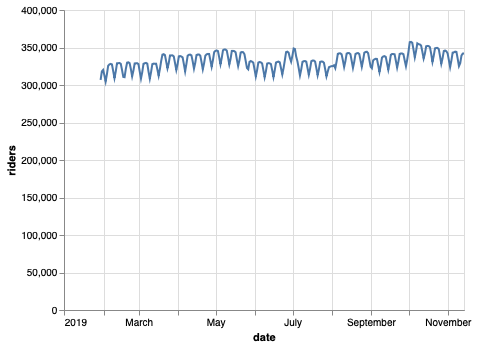

In [18]:
ser = pd.DataFrame(
    pd.Series(df.groupby("date").apply(lambda x: x.riders.sum()))
    .rolling(window=30)
    .mean()
).reset_index()
ser.columns = ["date", "riders"]

alt.Chart(ser).mark_line().encode(x="date:T", y="riders")

In [19]:
totaled = pd.DataFrame(
    df.groupby(["start", "stop"]).apply(lambda x: sum(x.riders))
).reset_index()
totaled.columns = ["start", "stop", "rides"]

In [20]:
totaled.head()

,start,stop,rides
0,12TH,12TH,16656
1,12TH,16TH,86846
2,12TH,19TH,16669
3,12TH,24TH,72346
4,12TH,ANTC,42513


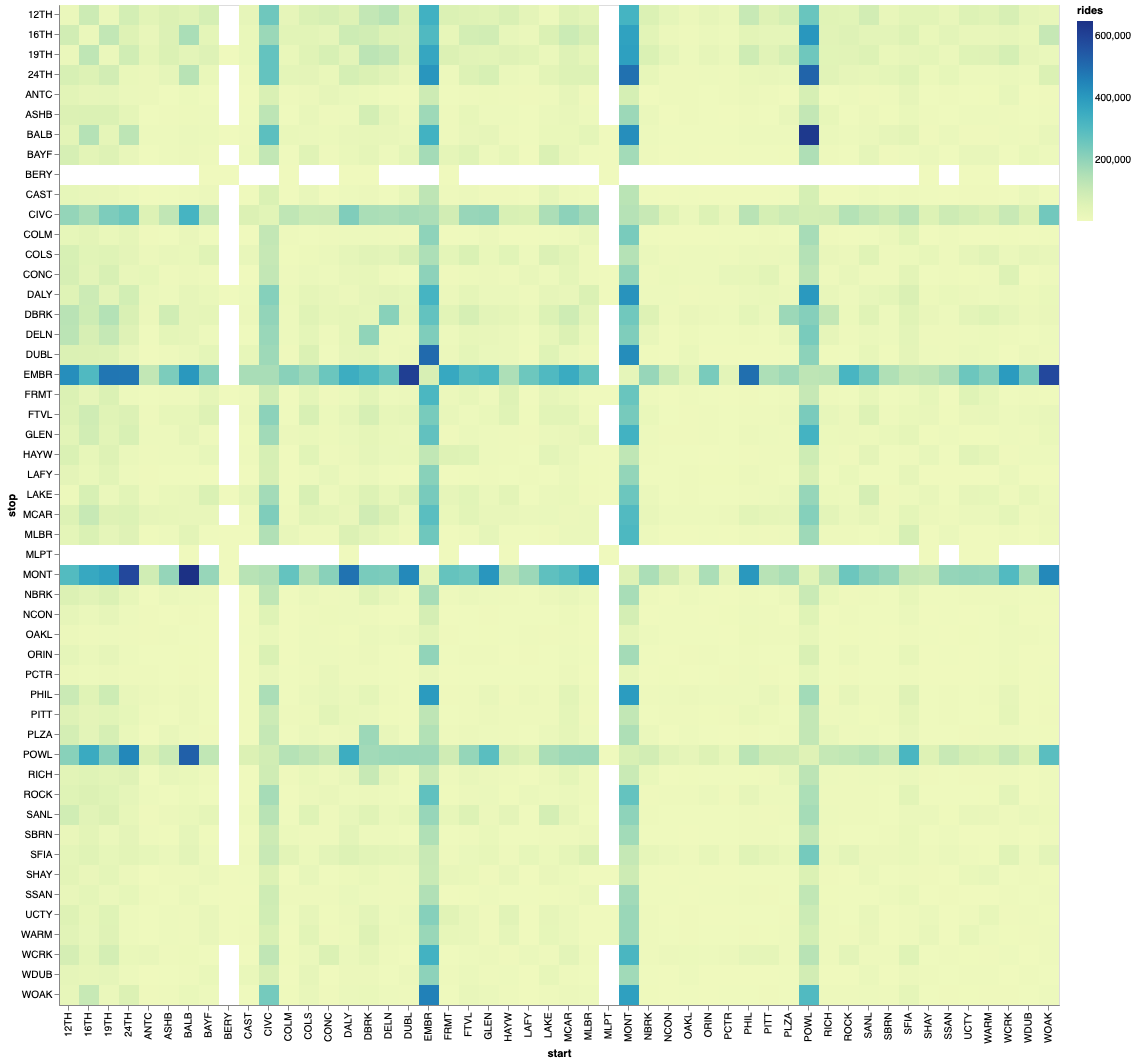

In [21]:
alt.Chart(totaled).mark_rect().encode(
    x="start:O", y="stop:O", color="rides", tooltip=["start", "stop", "rides"]
)